# Cookbook for pydna

Björn Johansson
CBMA
University of Minho
Braga
Portugal

![logo](logo.png "logo")

## What is pydna?

Pydna is a python package that provides functions and data types to deal with double stranded DNA. It depends on Biopython (a python bioinformatics package), networkx (a graph theory package) and numpy (a mathematics package).

## What does Python dna provide?

Python dna provide classes and functions for molecular biology using python. Notably, PCR, cut and paste cloning (sub-cloning) and homologous recombination between linear DNA fragments are supported. Most functionality is implemented as methods for the double stranded DNA sequence record classes “Dseq” and "Dseqrecord", which are a subclasses of the Biopython Seq and SeqRecord classes, respectively.

Pydna was designed to semantically imitate how sub-cloning experiments are typically documented in scientific literature. One use case for pydna is to create executable documentation for a sub-cloning experiment. The pydna code unambiguously describe the experiment, and can be executed to yield the sequence of the of the resulting DNA molecule(s) and all intermediary steps.  Pydna code describing a sub cloning is reasonably compact and also meant to be easily readable.

Typical usage at the command line could look like the sequence of cells below.

In order to access the pydna functionality, pydna has to be imported:

In [1]:
import pydna

A small Dseq object can be created directly. The Dseq class which is a double stranded version of the [Biopython](http://biopython.org/) [Seq](http://biopython.org/wiki/Seq) class.

In [2]:
seq = pydna.Dseq("GGATCCAAA","TTTGGATCC", ovhg=0)
seq

Dseq(-9)
GGATCCAAA
CCTAGGTTT

The Dseq class is the main pydna data type together with the Dseqrecord class which is a double stranded version of the [BioPython](http://biopython.org/) [SeqRecord](http://biopython.org/wiki/SeqRecord) class.

The Dseq object was initialized using two strings and a value for the stagger (ovhg) between the DNA strands in the 5' (left) extremity. This is of course not a practical way of creating a Dseq object in most cases, but there are other methods as we will see further on.

The Dseq object comes with a cut method that takes one or more restriction enzymes as arguments. A list is returned with the fragments produced in the digestion:

In [3]:
from Bio.Restriction import BamHI
a, b = seq.cut(BamHI)

The two fragments formed (a and b) have the structure we would expect.

In [4]:
a

Dseq(-5)
G
CCTAG

In [5]:
b

Dseq(-8)
GATCCAAA
    GTTT

The fragments a and b formed in the example above can be religated together by simply adding them together.

a+b gives us the old fragment back.

In [6]:
a+b

Dseq(-9)
GGATCCAAA
CCTAGGTTT

b+a gives us a fragment with the stycky ends facing outwards.

In [7]:
b+a

Dseq(-13)
GATCCAAAG
    GTTTCCTAG

We can add as many fragment together as we want, as long as the sticky ends are compatible.

In [8]:
b+a+b

Dseq(-17)
GATCCAAAGGATCCAAA
    GTTTCCTAGGTTT

The ligation below will not work as the sticky ends are not compatible. The Dseq objects keep track of the structure of the DNA ends and only allow ligation of compatible fragments. The last line of the error message below gives an idea of what is wrong.

In [9]:
b+a+a

TypeError: sticky ends not compatible!

## Example 1: Sub cloning by restriction digestion and ligation

The objective of this example is to simulate a cut and paste cloning from the literature using pydna.
The example is the construction of the vector YEp24PGK_XK which is described on page 4250 in the publication below:

In [10]:
from IPython.display import HTML
HTML('<iframe src=http://www.ncbi.nlm.nih.gov/pmc/articles/PMC93154 width=600 height=600></iframe>')

### Strategy

1. the [XKS1 gene](http://www.yeastgenome.org/locus/S000003426/overview) from _Saccharomyces cerevisiae_ is amplified by PCR using two primers called primer1 and primer3. The primers has tails which add restriction sites for BamHI to the ends of the  XKS1 gene. The sequences of both primers are available in Johansson et al. 

2. The YEp24PGK plasmid is linearized with the restriction endonuclease [BglII](http://rebase.neb.com/rebase/enz/BglII.html).

3. PCR product is digested with the restriction endonuclease [BamHI](http://rebase.neb.com/rebase/enz/BamHI.html).

4. Th two molecules are mixed and ligated.

The figure below shows an image outlining the strategy.

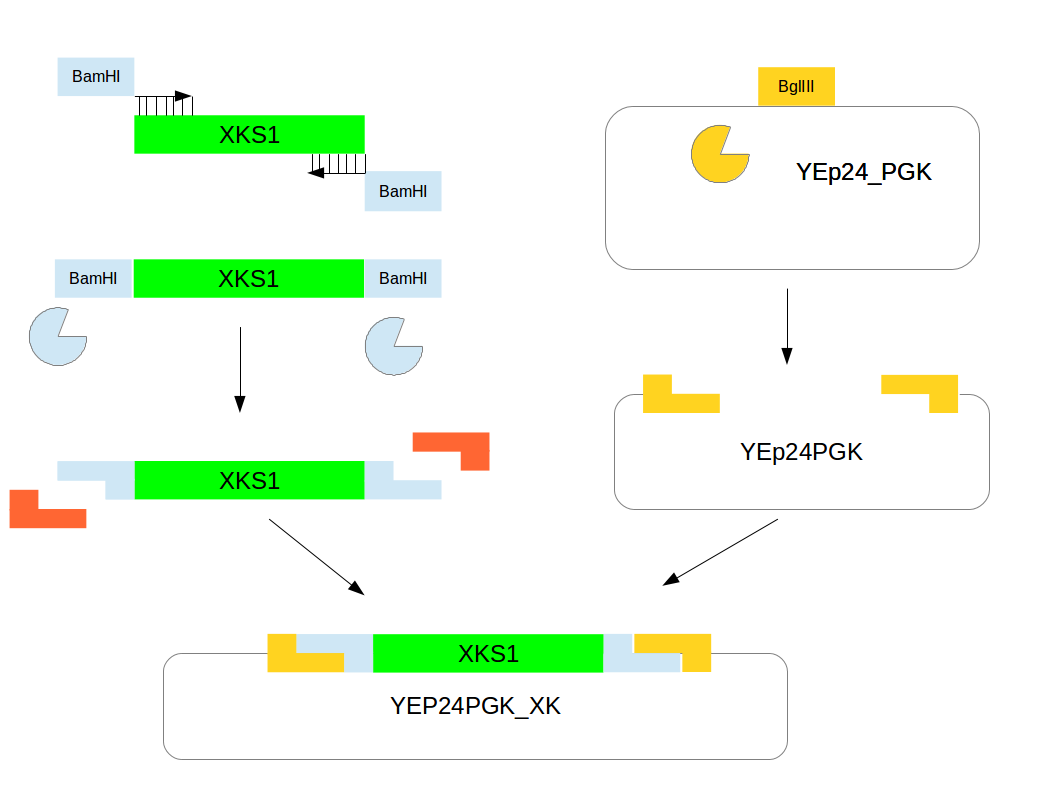

In [11]:
from IPython.core.display import Image
Image('figure1.png',width=600)

The p1 and p3 primers sequences were given in Johansson et al. The primer sequences are read into [BioPython](http://biopython.org/) [SeqRecord](http://biopython.org/wiki/SeqRecord) objects. Primers are single stranded DNA molecules, so SeqRecords are adequate for describing them.

In [12]:
p1, p3 = pydna.parse_primers('''
>primer1
GCGGATCCTCTAGAATGGTTTGTTCAGTAATTCAG

>primer3
AGATCTGGATCCTTAGATGAGAGTCTTTTCCAG
''')

The XKS1 gene sequence is dowloaded from [genbank](https://www.ncbi.nlm.nih.gov/nuccore/NC_001139.9?from=886073&to=887875&report=genbank&strand=true) like so:
    
1. Go to the [SGD page](http://www.yeastgenome.org/locus/S000003426/overview) of the XKS1 gene 
2. Entrez Gene link at the bottom of the page goes to the Genbank site for the gene
3. Go to the NCBI Reference Sequences (RefSeq) section and click on the Genbank link
4. The third line of the genbank file contains the accession entry: `ACCESSION   NC_001139 REGION: complement(886073..887875)`
5. Copy and paste the text `NC_001139 REGION: complement(886073..887875)` as the argument for the pydna.genbank function below.

This is but one of many ways to establish sequences in pydna.

In [13]:
xks1 = pydna.genbank("NC_001139 REGION: complement(886073..887875)")

The XKS1 gene has the expected size (see SGD link above).

In [14]:
xks1

Dseqrecord(-1803)

The sequence starts with an `ATG` start codon and ends with a `TAA` stop codon.

In [15]:
xks1.seq

Dseq(-1803)
ATGT..CTAA
TACA..GATT

The convenience methods isorf can tell if the sequence is an open reading frame or not.

In [16]:
xks1.isorf()

True

The PCR product sequence is simulated from the primers and the template sequence using the pydna.pcr function. The pydna. Amplicon class offer greater control over the pcr parameters, but this is not needed here.

In [17]:
PCR_prod = pydna.pcr(p1, p3, xks1)

We import restiction enzymes [BamHI](http://rebase.neb.com/rebase/enz/BamHI.html) and [BglII](http://rebase.neb.com/rebase/enz/BglII.html) from BioPython.

In [18]:
from Bio.Restriction import BamHI, BglII

Digesting the PCR product yield three fragments, two short stuffer fragments and the insert that we would like to clone. 

In [19]:
stuffer1, insert, stuffer2 = PCR_prod.cut(BamHI)

The insert has the expected sticky ends.

In [22]:
insert.seq

Dseq(-1819)
GATCCTCT..TAAG    
    GAGA..ATTCCTAG

The YEp24PGK vector is available from [Genbank](https://www.ncbi.nlm.nih.gov/nuccore/KC562906).

In [23]:
YEp24PGK = pydna.genbank("KC562906")

The plasmid has the expected size (see Genbank link above).

In [24]:
YEp24PGK

Dseqrecord(o9637)

The YEp24PGK is linearized with the BglII enzyme. This method will make sure that the molecule is linearized i.e. the enzyme only cuts in one place.

In [25]:
YEp24PGK_BglII = YEp24PGK.linearize(BglII)

The linear vector has the expected size and structure.

In [26]:
YEp24PGK_BglII

Dseqrecord(-9641)

The two fragments are ligated together and looped, which means that the far ends of both molecules ligate to form a circular product.

In [27]:
YEp24PGK_XK = ( YEp24PGK_BglII + insert ).looped() 

The resulting molecule i circular and has the expected size, 11452 bp.

In [28]:
YEp24PGK_XK

Dseqrecord(o11452)

In [29]:
YEp24PGK_XK.write("YEp24PGK_XK.txt")

### [YEp24PGK_XK](YEp24PGK_XK.txt)

## Example 2: Sub cloning by homologous recombination

The construction of the vector pGUP1 is described in the publication:

In [31]:
HTML('<iframe src=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1474799 width=600 height=600></iframe>')

Our objective is to replicate the cloning steps using pydna so that we can have the final sequence of the plasmid.

The cloning is described in the paper on the upper left side of page 2637:

    "The expression vectors harboring GUP1 or GUP1H447A were obtained as follows: the open reading frame of GUP1
    was amplified by PCR using plasmid pBH2178 (kind gift from Morten Kielland-Brandt) as a template and using
    primers  and , underlined sequences being homologous to the target vector pGREG505 (Jansen et al., 2005). 
    The PCR fragment was purified by a PCR purification kit (QIAGEN, Chatsworth, CA) and introduced into 
    pGREG505 by co transfection into yeast cells thus generating pGUP1 (Jansen et al., 2005)."

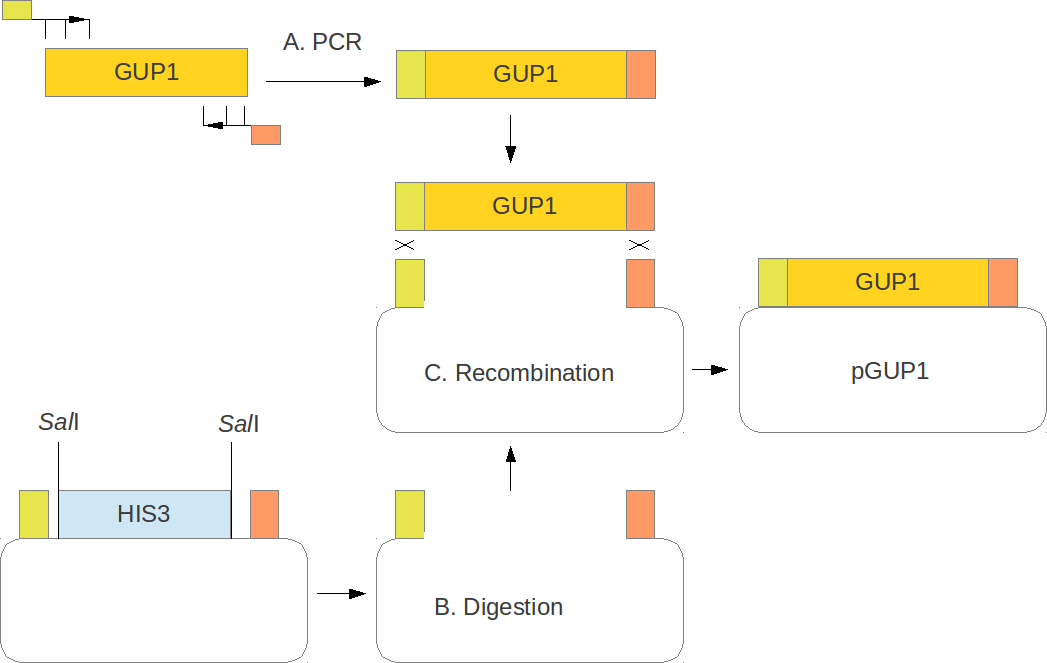

In [32]:
from IPython.core.display import Image
Image('figure2.png',width=600)

Briefly, two primers (GUP1rec1sens and GUP1rec2AS) were used to amplify the GUP1 gene from _Saccharomyces cerevisiae_ chromosomal DNA.

[Jansen G, Wu C, Schade B, Thomas DY, Whiteway M. 2005. Drag&Drop cloning in yeast. Gene, 344: 43–51.](http://www.sciencedirect.com/science/article/pii/S0378111904006420)

Jansen et al describe the pGREG505 vector and that it is digested with SalI before cloning. The SalI digests the vector in two places, so a fragment containing the HIS3 gene is removed.

This is a cloning in three steps (see above figure):

1. PCR of the GUP1 locus using GUP1rec1sens GUP1rec2AS, resulting in
   a linear insert (A). The primer sequences are given in Bosson et al. 
   The template sequence can be found at Saccharomyces Genome Database (SGD)

2. Digestion of the plasmid pGREG505 with SalI, This step is not
   mentioned explicitly in Bosson et. al, but is evident from Jansen et al. (B). 
   This digestion removes a DNA fragment containing the HIS3 marker gene
   from the final construct. The sequence of the pGREG505 plasmid (as well as
   the physical plasmid itself) can be obtained from 
   [EUROSCARF](http://www.euroscarf.de/plasmid_details.php?accno=P30350)

3. Recombination between the linear insert and the linear vector (C).


The SalI sites are visible in the plasmid drawing of pGREG505 below:


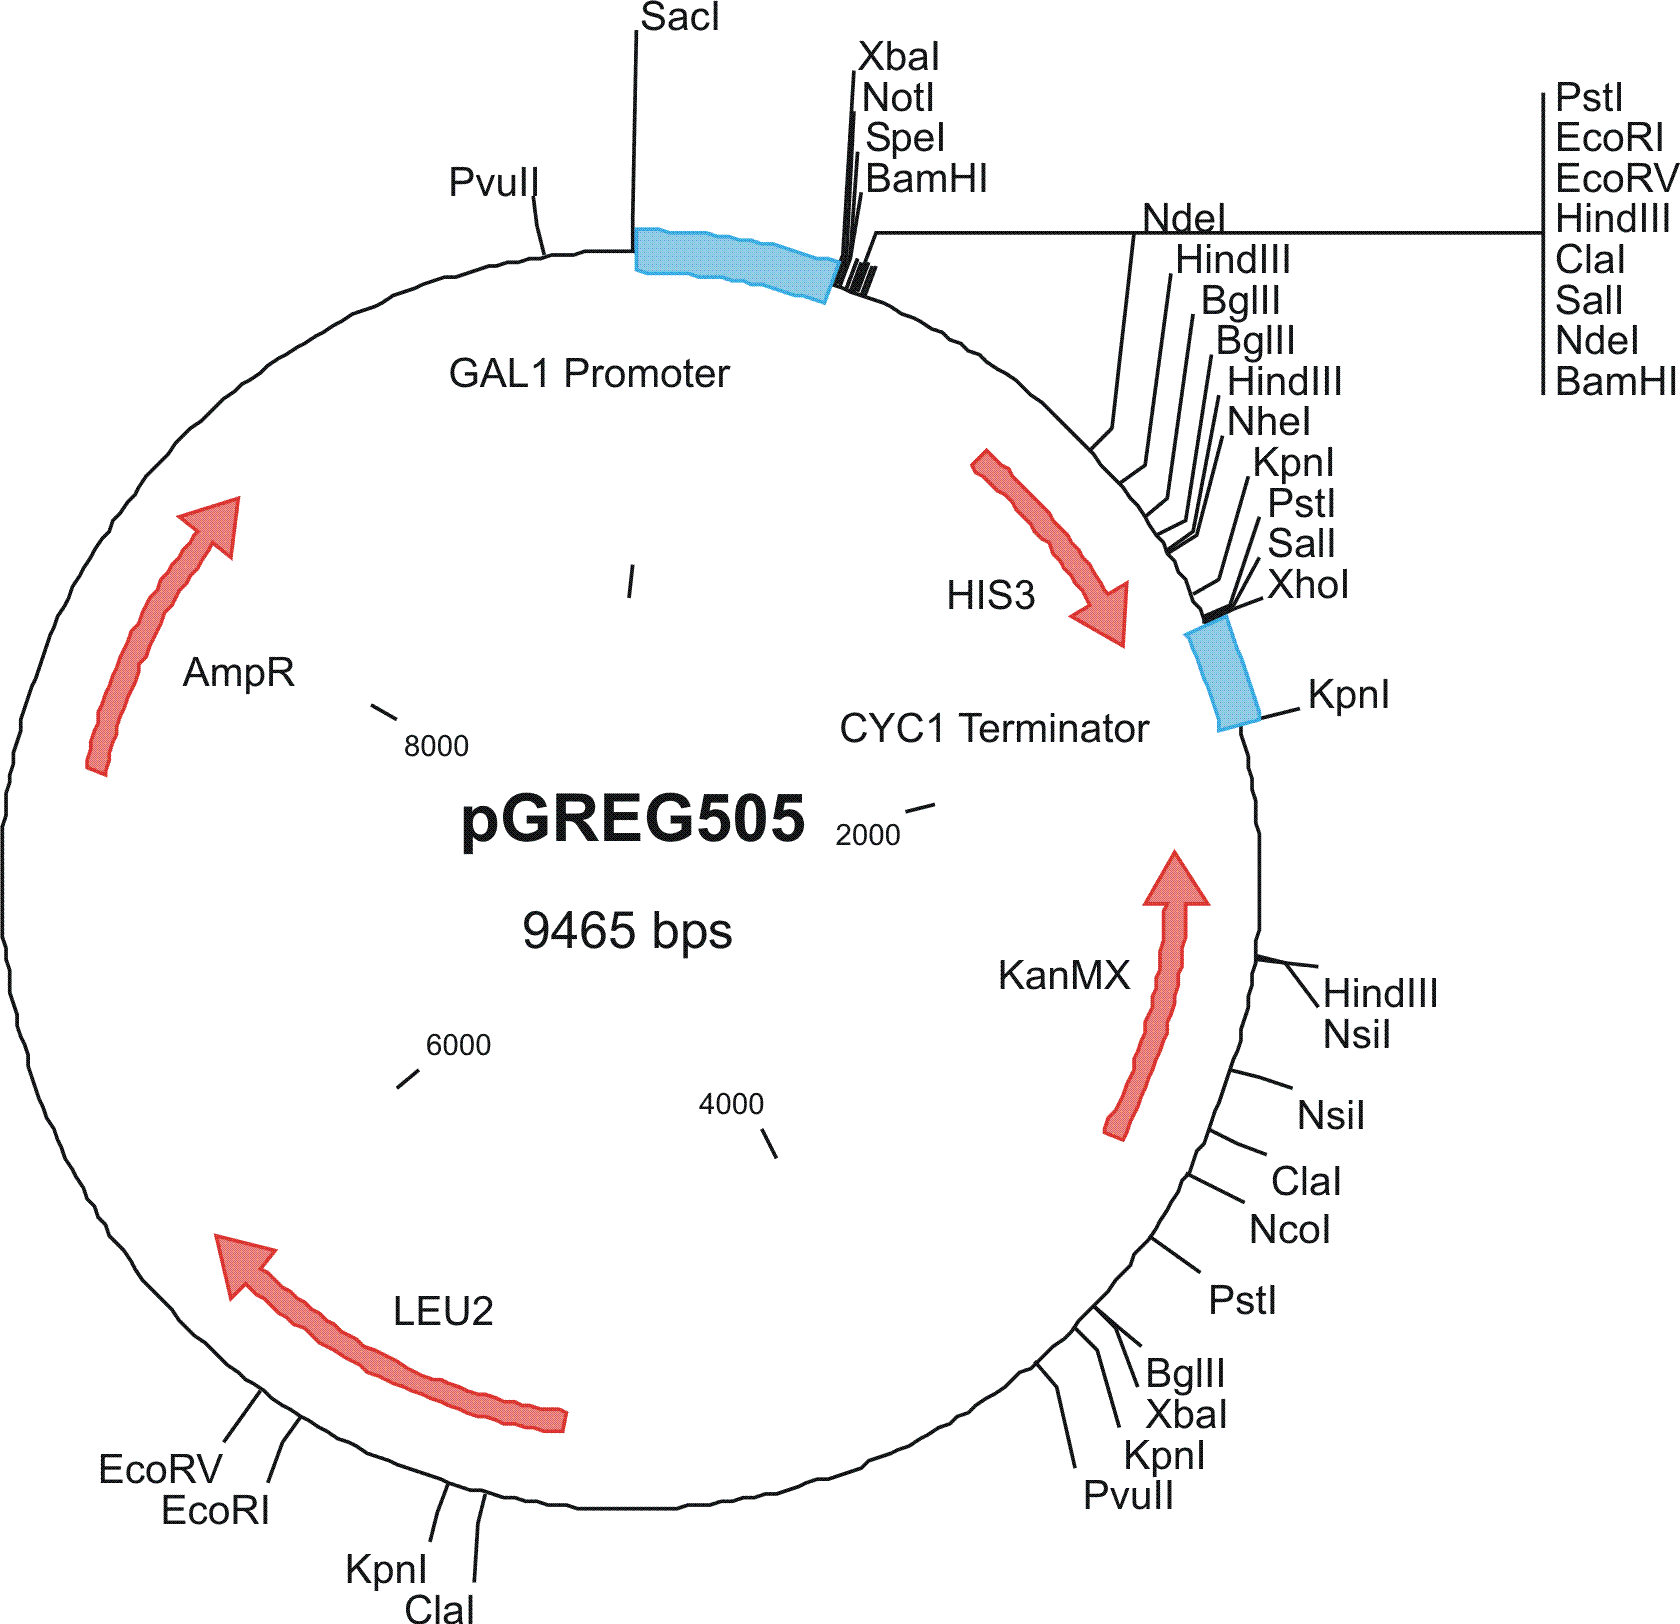

In [33]:
Image('pGREG505.png',width=400)

We will now replicate the cloning procedure using pydna.

In [34]:
import pydna

The primer sequences are read into [BioPython](http://biopython.org/) [SeqRecord](http://biopython.org/wiki/SeqRecord) objects. Primers are single stranded DNA molecules, so 
SeqRecords are adequate for describing them.

In [35]:
GUP1rec1sens, GUP1rec2AS = pydna.parse_primers('''
>GUP1rec1sens 
gaattcgatatcaagcttatcgataccgatgtcgctgatcagcatcctgtc

>GUP1rec2AS
gacataactaattacatgactcgaggtcgactcagcattttaggtaaattccg''')

The template sequences is th GUP1 locus from SGD. It is read remotely from [Genbank]() into a pydna Dseqrecord object.

In [36]:
GUP1_locus = pydna.genbank("NC_001139 REGION: complement(350616..352298)")

The pGREG505 vector sequence is downloaded from [EUROSCARF](http://www.euroscarf.de/files/dna/P30350/P30350%20%282013-10-11%2013_49_14%29.dna). This sequence is unfortunately not correctly formatted according to the [Genbank format](https://www.ncbi.nlm.nih.gov/Sitemap/samplerecord.html).

This is unfortunately not uncommon to find "Genbank" files online that are not properly formatted. The BioPython parser on which the pydna parser based is somewhat sensitive, which can be a good or a bad thing depending on the situation. 

Pydna provide a Genbank cleaning function that tries to salvage as much as possible of the sequence.
In the cells below

1. file is dowloaded as text
2. cleaned using the gbtext_clean function
3. read into a Dseqrecord object using the read function
4. The cSEGUID checksum is calculated in order to confirm the integrity of the sequence.

The cSEGUID method provide a checksum for circular sequences. Look at this [blog post](http://ochsavidare.blogspot.pt/2016/02/checksum-for-circular-biological.html) for further information on the cSEGUID checksum and its definition. The cSEGUID checksum can be caluclated for any sequence with a GUI app called SEGUID calculator. This can be found [here](https://github.com/BjornFJohansson/seguid_calculator). The cSEGUID is the identical with the checksum calulated with the cSEGUID checksum, proving that the file cleanup did not alter the sequence. It is probably best to save a properly formatted sequence in a local file that has been verified.

In [37]:
gbtext=pydna.download_text("http://www.euroscarf.de/files/dna/P30350/P30350%20(2013-10-11%2013_49_14).dna")
cleaned_gb_text=pydna.gbtext_clean(gbtext)
pGREG505 = pydna.read(cleaned_gb_text.gbtext)
pGREG505.cseguid()

UVIuDWAVWkUAD0_U-wFHWG7ARmE

The PCR product sequence is simulated from the primers and the template sequence using the pydna.pcr function. The pydna.Amplicon class offer greater control over the pcr parameters.

In [38]:
insert = pydna.pcr(GUP1rec1sens, GUP1rec2AS, GUP1_locus)

In [39]:
insert.figure()

                            5ATGTCGCTGATCAGCATCCTGTC...CGGAATTTACCTAAAATGCTGA3
                                                       |||||||||||||||||||||| tm 54.5 (dbd) 63.1
                                                      3gccttaaatggattttacgactcagctggagctcagtacattaatcaatacag5
5gaattcgatatcaagcttatcgataccgatgtcgctgatcagcatcctgtc3
                             ||||||||||||||||||||||| tm 62.3 (dbd) 71.1
                            3TACAGCGACTAGTCGTAGGACAG...GCCTTAAATGGATTTTACGACT5

In [40]:
insert.program()


Taq (rate 30 nt/s) 35 cycles             |1742bp
95.0°C    |95.0°C                 |      |Tm formula: Biopython Tm_NN
|_________|_____          72.0°C  |72.0°C|SaltC 50mM
| 03min00s|30s  \         ________|______|Primer1C 1.0µM
|         |      \ 53.9°C/ 0min52s| 5min |Primer2C 1.0µM
|         |       \_____/         |      |GC 37%
|         |         30s           |      |4-12°C

We need to import the [SalI](http://rebase.neb.com/rebase/enz/SalI.html) restriction enzyme from Biopython.

In [41]:
from Bio.Restriction import SalI

We cut the vector with SalI using the cut method. 

In [42]:
linear_vector, his3 = pGREG505.cut(SalI)

The linearized pGREG505 has 8301 bp and is of course linear.

In [43]:
linear_vector

Dseqrecord(-8301)

The pydna Assembly class can simulate [homologous recombination](https://en.wikipedia.org/wiki/Homologous_recombination) as well as [fusion PCR](https://en.wikipedia.org/wiki/Overlap_extension_polymerase_chain_reaction) and [Gibson assembly](https://en.wikipedia.org/wiki/Gibson_assembly).


The variable asm, below will contain all possible recombination products between the two linear fragments.
The table below gives an overview of the recombination products as well as parameters used. The two last rows show that one circular [9981] and four linear products [10013] [10011] [32] and [30] were formed.

We are only interested in the circular product, since the pGUP1 plasmid is expected to be circular.

In [44]:
asm = pydna.Assembly((linear_vector, insert))

In [45]:
asm

Assembly:
Sequences........................: [8301] [1742]
Sequences with shared homologies.: [8301] [1742]
Homology limit (bp)..............: 25
Number of overlaps...............: 2
Nodes in graph(incl. 5' & 3')....: 4
Only terminal overlaps...........: No
Circular products................: [9981]
Linear products..................: [10013] [10011] [32] [30]

The cirular product can be acessed from the circular_products property of the asm object.

In [46]:
candidate = asm.circular_products[0]

We can study this further by accessing the figure method. We can see from the figure below, that the circular product is what we want.

In [47]:
candidate.figure()

 -|pGREG505|28
|           \/
|           /\
|           28|1742bp_PCR_prod|30
|                              \/
|                              /\
|                              30-
|                                 |
 ---------------------------------

The sync method below makes sure that our new vector starts from the same position as the pGREG vector did. This makes our recombinant plasmid easier to read and compare in a plasmid editor. Pydna can incorporate the free [ApE](http://biologylabs.utah.edu/jorgensen/wayned/ape/) plasmid editor in a way that it can be opened on any sequence object direcly from a Jupyter notebook or an IPython shell.

In [48]:
pGUP1 = candidate.synced(pGREG505) 

Finally we write the sequence to a local file.

In [49]:
pGUP1.write("pGUP1.gb")

### [pGUP1](pGUP1.gb)